In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
import math
import time
from numpy import random
from sklearn.cluster import KMeans
from scipy.spatial import distance
from numpy import linalg as LA
from sklearn import metrics

def my_spectral_cluster(fea,k):
    N=np.shape(fea)[0]
    dist=distance.cdist(fea,fea, 'euclidean')
    MeanDiff = np.mean(dist)
    W=np.exp(-(np.square(dist))/2*100)
    d=np.sum(W,axis=1)
    D=np.diag(d)
    L=D-W
    
    eval,evec = LA.eig(L)
    eval_idx=np.argsort(eval)
    evec_k=evec[:,eval_idx[0:k]]
    
    kmeans= KMeans(n_clusters=k)
    kmeans.fit(evec_k)
    return kmeans.labels_

def getRepresentativesByHybridSelection(fea, pSize, cntTimes):
    N=np.shape(fea)[0]
    if pSize>N:
        pSize = N
    bigPSize = cntTimes*pSize
    if bigPSize>N:
        bigPSize = N
    
    bigRpFea_Idx = random.randint(N,size=(bigPSize))
    kmeans=KMeans(n_clusters=pSize)
    kmeans.fit(fea[bigRpFea_Idx])
    return kmeans.cluster_centers_

def Tcut_for_bipartite_graph(B,Nseg):
    
    dx=np.sum(B,axis=1)
    Dx=np.diag(1./dx)
    Wy=B.T@Dx@B
    
    ### compute Ncut eigenvectors
    # normalized affinity matrix
    d=np.sum(Wy,axis=1)
    D=np.diag(1./np.sqrt(d))
    nWy=D@Wy@D
    nWy=(nWy.T+nWy)/2
    
    #computer eigenvectors
    #这里用的特征分解是 U-SPEC论文的参考文献[6]中提到‘the Lanczos method ’[13]的方法，待研究*
    eval,evec = LA.eig(nWy)
    idx=np.argsort(eval)
    Ncut_evec=D@evec[:,idx[:-Nseg-1:-1]]
    
    #转化为原特征分解问题的特征向量
    #compute the Ncut eigenvectors on the entire bipartite graph (transfer!)
    evec=Dx@B@Ncut_evec
    
    #归一化处理
    #normalize each row to unit norm
    evec=evec/np.sqrt(np.sum(np.square(evec),axis=1)+1e-10).reshape((-1,1))
    
    #k-means
    kmeans= KMeans(n_clusters=Nseg)
    kmeans.fit(evec)
    return kmeans.labels_

def U_SPEC(Fea,k,p,Knn):
    N=np.shape(Fea)[0]
    #p=20
    #Knn=3
    
    ##Get p representatives by hybrid selection
    RpFea = getRepresentativesByHybridSelection(Fea, p, 10)
    
    
    ## 一 Approx. KNN
    #1.将RpFea 用kmeans分成 cntRepCls种的聚类
    cntRepCls=math.floor(np.sqrt(p))
    kmeans = KMeans(n_clusters=cntRepCls)
    kmeans.fit(RpFea)
    #2.得到cntRepCls个聚类中心
    repClsCenters=kmeans.cluster_centers_
    #3.计算N个点到聚类中心的距离
    centerDist=distance.cdist(Fea, repClsCenters, 'euclidean')

    
    ## 二 对N个中每一个点，找到最近的一类聚类
    ##Find the nearest rep-cluster (in RpFea) for each object
    minCenterIdxs=np.argmin(centerDist,axis=1)
    cntRepCls=np.shape(repClsCenters)[0]
    
    
    ## 三 对N个中每一个点，找到该点最近一类中距最近的代表点
    ## Then find the nearest representative in the nearest rep-cluster for each object.
    nearestRepInRpFeaIdx = np.zeros((N,1),dtype=int)
    temp_nearestRepInRpFeaIdx = np.zeros((N,1))
    for i in range(0,cntRepCls):
        #"nonzero" 输出数组为向量（0，n）
        RpFea_array_of_center_i=np.nonzero(kmeans.labels_==i) #找到RpFea中聚类中心为i的点，求其在RpFea中索引
        Fea_array_of_mincenter_i=np.nonzero(minCenterIdxs==i) #找到Fea中以第i个聚类中心为最近的中心的点，求其在Fea中索引

        #计算“Fea中以第i个聚类中心为最近的中心的点”到 “RpFea中聚类中心为i的点”的距离，求出最小值得出其索引（but是在第i类聚类范围内的索引）
        nearestRepInRpFeaIdx[Fea_array_of_mincenter_i]=np.asarray(np.argmin(distance.cdist(Fea[Fea_array_of_mincenter_i],RpFea[RpFea_array_of_center_i],'euclidean'),axis=1)).reshape((-1,1))

        #这里将“RpFea_array_of_center_i”数组转化为列向量
        RpFea_array_of_center_i=np.asarray(RpFea_array_of_center_i).reshape((-1,1))

        #这里求最小值在RpFea中的索引,
        #需改进：这里"nearestRepInRpFeaIdx[Fea_array_of_mincenter_i]"要化成行向量才可以进行在列向量“RpFea_array_of_center_i”索引
        nearestRepInRpFeaIdx[Fea_array_of_mincenter_i]=RpFea_array_of_center_i[nearestRepInRpFeaIdx[Fea_array_of_mincenter_i].reshape((1,-1))]
    #将nearestRepInRpFeaIdx从（n，1）换为（n，0）维的向量 
    #因为用数组索引要用（n，0）维向量
    nearestRepInRpFeaIdx=nearestRepInRpFeaIdx.reshape((-1,))
    
    

    ## 四 对N个中每一个点，计算到K’个候选代表点的距离
    #For each object, compute its distance to the candidate neighborhood of its nearest representative (in RpFea)
    neighSize=5*Knn #候选点的个数K'
    if neighSize>p:
        neighSize=p
    RpFeaW=distance.cdist(RpFea,RpFea, 'euclidean')
    RpFeaKnnIdx=np.argsort(RpFeaW,axis=1)
    #取‘RpFeaW’中最近的前‘neighSize’列对应的代表点最为候选点
    #RpFeaKnnIdx为其在‘RpFeaW’的索引（按升序）
    RpFeaKnnIdx=RpFeaKnnIdx[:,0:neighSize]
    RpFeaKnnDist=np.zeros((N,neighSize))

    for i in range(0,p):
        FeaIdx_array_of_nearest_RpfeaIdx_i=np.nonzero(nearestRepInRpFeaIdx==i)
        RpFeaKnnDist[FeaIdx_array_of_nearest_RpfeaIdx_i]=distance.cdist(Fea[FeaIdx_array_of_nearest_RpfeaIdx_i],RpFea[RpFeaKnnIdx[i,:]],'euclidean')
    RpFeaKnnIdxFull=RpFeaKnnIdx[nearestRepInRpFeaIdx]


    ## 五 Get the final KNN according to the candidate neighborhood.
    knnDist=np.zeros((N,Knn))
    knnTmpIdx=np.zeros((N,Knn),dtype=int)
    knnIdx=np.zeros((N,Knn),dtype=int)
    for i in range(0,Knn):
        #找到‘RpFeaKnnDist’中最小的前Knn个，
        knnDist[:,i]=np.min(RpFeaKnnDist,axis=1)
        knnTmpIdx[:,i]=np.argmin(RpFeaKnnDist,axis=1)
        #在‘RpFeaKnnDist’中找到的行最小值设为无穷大
        RpFeaKnnDist[np.arange(N),knnTmpIdx[:,i]]=1e100
        #‘knnTmpIdx’为其在‘RpFeaKnnDist’中的索引，代入‘RpFeaKnnIdxFull’得到在RpFea中的索引
        knnIdx[:,i]=RpFeaKnnIdxFull[np.arange(N),knnTmpIdx[:,i]]


    ## 六 Compute the cross-affinity matrix B for the bipartite graph
    #use the mean distance as the kernel parameter $\sigma$    
    knnMeanDiff = np.mean(knnDist)
    #距离矩阵化成高斯相关性矩阵
    Gsdx=np.exp(-(np.square(knnDist))/2*knnMeanDiff**2)
    B=np.zeros((N,p))
    for i in range(0,Knn):
        #得到稀疏子矩阵
        B[np.arange(N),knnIdx[:,i]]=Gsdx[:,i]
        
        
    ##七 用Tcut法进行特征分解
    labels=Tcut_for_bipartite_graph(B,2)
    return labels


import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import make_moons
Fea, y1 = make_moons(n_samples=1000, noise=0.05, random_state=0)

#谱聚类算法

total_score=0
for i in range(10):
    time_start=time.time()
    labels=my_spectral_cluster(Fea,2)
    time_over=time.time()
    time_cost=time_over-time_start
    NMI_score=metrics.normalized_mutual_info_score(labels,y1)
    if i==0:
        print('谱聚类算法：')
    print("第 %d 轮:NMI得分:%f|时间：%f s " %(i+1,NMI_score,time_cost))
    total_score=total_score+NMI_score
average_score=total_score/10
print("10轮平均NMI得分：",average_score)


#U-SPEC
total_score=0
for i in range(10):
    time_start=time.time()
    labels=U_SPEC(Fea,2,20,3)
    time_over=time.time()
    time_cost=time_over-time_start
    NMI_score=metrics.normalized_mutual_info_score(labels,y1)
    if i==0:
        print('U-SPEC算法：')
    print("第 %d 轮:NMI得分:%f|时间：%f s " %(i+1,NMI_score,time_cost))
    total_score=total_score+NMI_score
average_score=total_score/10
print("10轮平均NMI得分：",average_score)

mglearn.discrete_scatter(Fea[:, 0],Fea[:, 1], labels, markers='o',s=5)



D:\installed\StudySofts\anaconda\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
D:\installed\StudySofts\anaconda\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


谱聚类算法：
第 1 轮:NMI得分:1.000000|时间：2.176099 s 
第 2 轮:NMI得分:1.000000|时间：2.018996 s 
第 3 轮:NMI得分:1.000000|时间：2.223829 s 
第 4 轮:NMI得分:1.000000|时间：2.050190 s 
第 5 轮:NMI得分:1.000000|时间：1.932612 s 
第 6 轮:NMI得分:1.000000|时间：1.983789 s 
第 7 轮:NMI得分:1.000000|时间：2.114456 s 
第 8 轮:NMI得分:1.000000|时间：2.016173 s 
第 9 轮:NMI得分:1.000000|时间：1.957497 s 
第 10 轮:NMI得分:1.000000|时间：2.093778 s 
10轮平均NMI得分： 1.0
U-SPEC算法：
第 1 轮:NMI得分:0.851463|时间：0.168250 s 
第 2 轮:NMI得分:0.887659|时间：0.163075 s 
第 3 轮:NMI得分:0.492226|时间：0.192024 s 
第 4 轮:NMI得分:0.686330|时间：0.217322 s 
第 5 轮:NMI得分:0.782819|时间：0.192407 s 
第 6 轮:NMI得分:0.757684|时间：0.161296 s 
第 7 轮:NMI得分:0.813908|时间：0.161377 s 
第 8 轮:NMI得分:0.934846|时间：0.195807 s 
第 9 轮:NMI得分:0.645419|时间：0.217309 s 
第 10 轮:NMI得分:0.742700|时间：0.241308 s 
10轮平均NMI得分： 0.7595054811311808


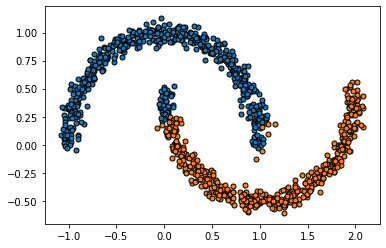

In [2]:
mglearn.discrete_scatter(Fea[:, 0],Fea[:, 1], labels, markers='o',s=5)